## Import the libraries

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB0, DenseNet121
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Reshape, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Declaring file paths for train and test folders

In [2]:
train_path = '/kaggle/input/skin-disease-dataset/train'
test_path = '/kaggle/input/skin-disease-dataset/test'

# Load data and create data generators for train, validation and test

In [3]:
# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Data augmentation and preprocessing for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15
)

# Preprocessing for validation and test
val_test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)

# Train generator
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Validation generator
validation_generator = val_test_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Test generator
test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 13859 images belonging to 31 classes.
Found 2430 images belonging to 31 classes.
Found 1724 images belonging to 31 classes.


### List the classes

In [11]:
classes = list(train_generator.class_indices.keys())
classes

['acne',
 'acrochordon',
 'actinic keratosis',
 'benign tumors',
 'bullous',
 'candidiasis',
 'drug eruption',
 'eczema',
 'erythma nodesum',
 'ichthyosis vulgaris',
 'infestations bites',
 'keloid',
 'lichen',
 'lupus',
 'measles',
 'melanoma',
 'melasma',
 'moles',
 'pseudofolliculitis barbae',
 'psoriasis',
 'rosacea',
 'seborrh keratoses',
 'seborrheic dermatitis',
 'skin cancer',
 'sunlight damage',
 'tinea',
 'unknown normal',
 'vascular tumors',
 'vasculitis',
 'vitiligo',
 'warts']

## Show samples of the images per class

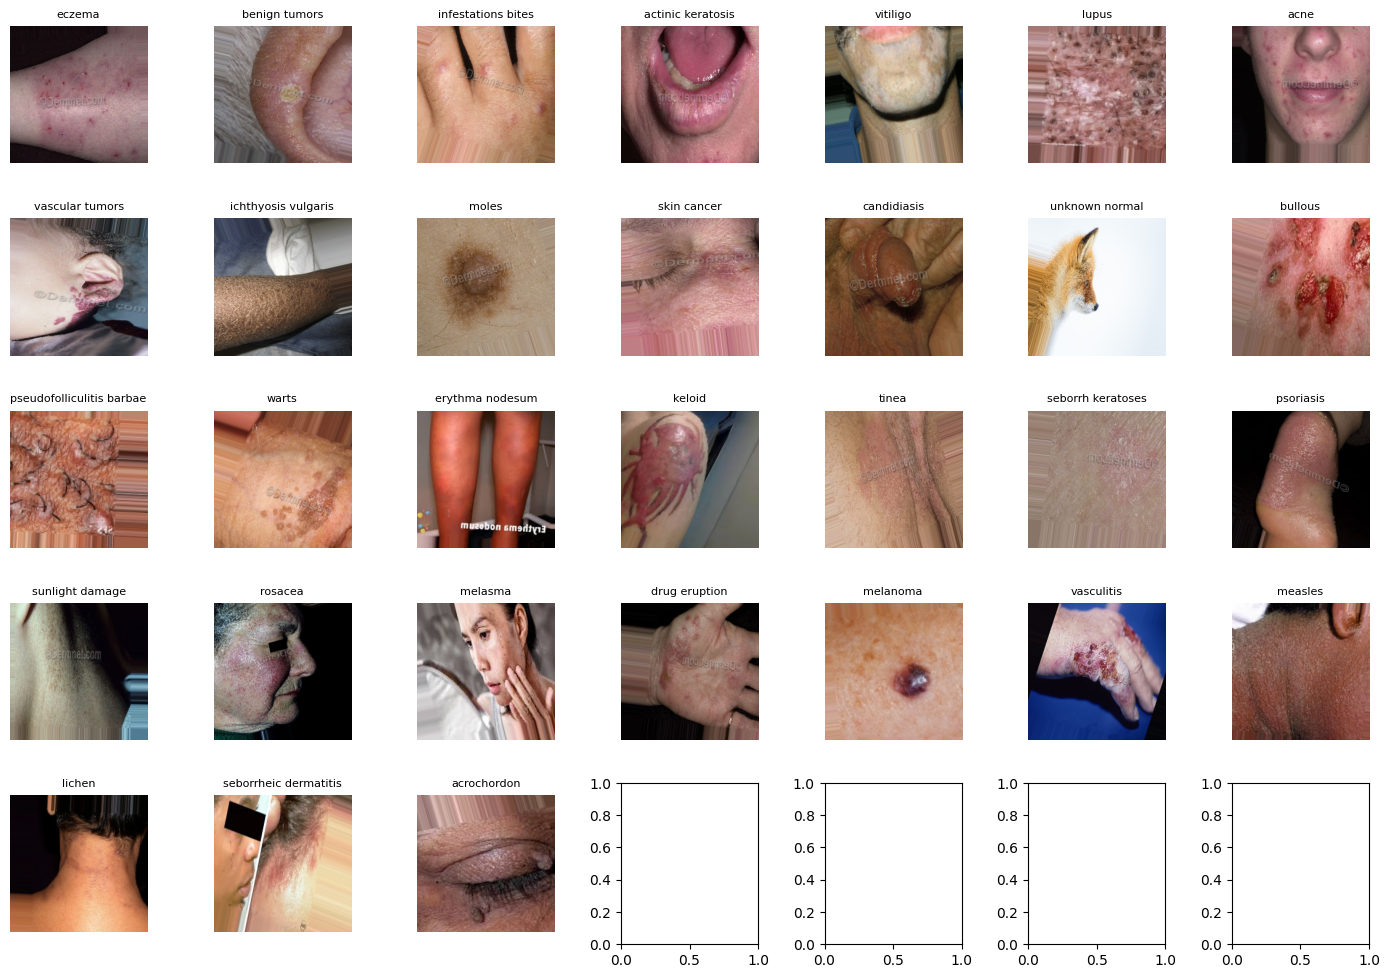

In [41]:
class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}  # Reverse mapping: {0: 'acne', 1: 'eczema', ...}

# Function to display one sample per class
def show_sample_images(generator, class_names):
    fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(14, 10))  # Adjust based on number of classes
    axes = axes.flatten()
    
    displayed_classes = set()
    
    for batch_images, batch_labels in generator:
        for img, label in zip(batch_images, batch_labels):
            class_index = np.argmax(label)  # Get class index
            class_name = index_to_class[class_index]  # Convert index to class name
            
            if class_name not in displayed_classes:
                ax = axes[len(displayed_classes)]
                ax.imshow(img)  
                ax.set_title(class_name, fontsize=8)
                ax.axis("off")  
                
                displayed_classes.add(class_name)
            
            if len(displayed_classes) >= len(class_names):  # Stop when all classes are displayed
                plt.tight_layout()
                plt.show()
                return

# Call the function with the class names
show_sample_images(train_generator, classes)

## Load the base model

In [6]:
# CNN-LSTM model definition using EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Build model with custom layers

In [17]:
num_classes = len(classes)

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Reshape((1, -1)),  # Reshape for LSTM input
    LSTM(128, return_sequences=False, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

## Compiling the model using Adam

In [18]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Show model summary

In [34]:
# summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 1, 1280)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 31)                  │          15,903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,474,746 (55.22 MB)

 Trainable params: 4,810,907 (18.35 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 9,621,816 (36.70 MB)

## Plot the model

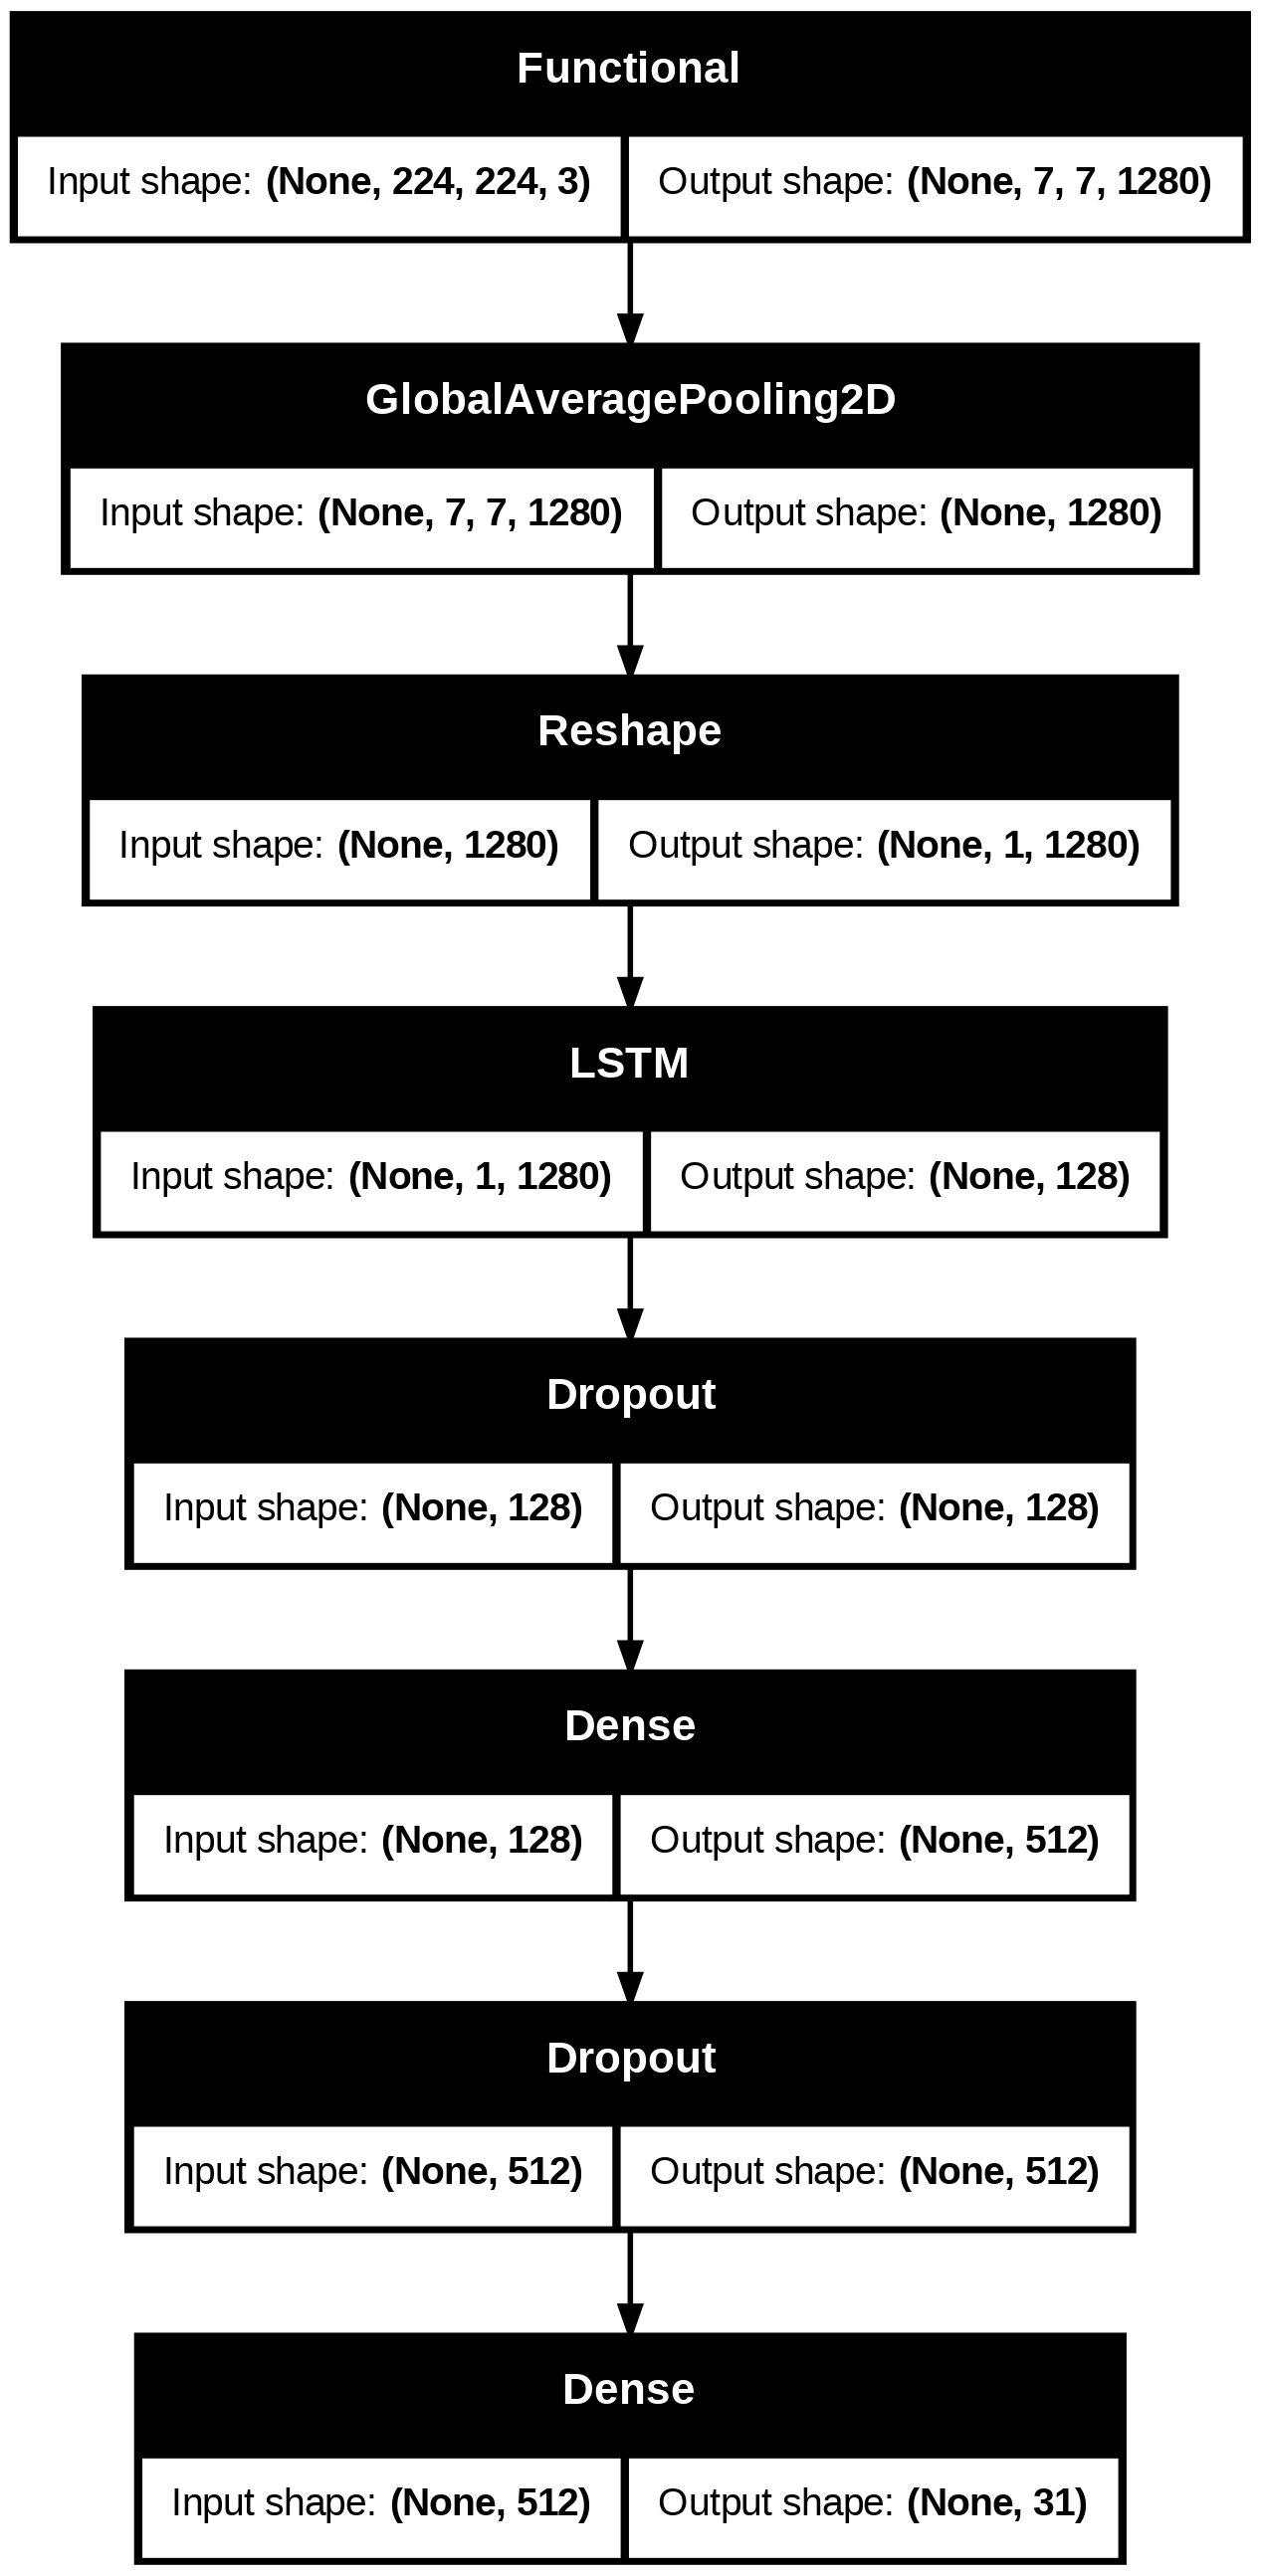

In [37]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='skin_disease_cnn.png', show_shapes=True)

## Defining the callbacks used while training

In [20]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## Training the model

In [22]:
history = model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[reduce_lr, early_stopping])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


434/434 ━━━━━━━━━━━━━━━━━━━━ 400s 731ms/step - accuracy: 0.0998 - loss: 9.7072 - val_accuracy: 0.1000 - val_loss: 5.1449 - learning_rate: 1.0000e-04
Epoch 2/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 212s 480ms/step - accuracy: 0.2370 - loss: 4.1384 - val_accuracy: 0.2963 - val_loss: 3.1423 - learning_rate: 1.0000e-04
Epoch 3/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 212s 480ms/step - accuracy: 0.2937 - loss: 3.0604 - val_accuracy: 0.3667 - val_loss: 2.6292 - learning_rate: 1.0000e-04
Epoch 4/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 211s 480ms/step - accuracy: 0.3419 - loss: 2.6579 - val_accuracy: 0.3938 - val_loss: 2.3656 - learning_rate: 1.0000e-04
Epoch 5/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 209s 474ms/step - accuracy: 0.3785 - loss: 2.4177 - val_accuracy: 0.4374 - val_loss: 2.1479 - learning_rate: 1.0000e-04
Epoch 6/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 209s 475ms/step - accuracy: 0.4189 - loss: 2.2218 - val_accuracy: 0.4757 - val_loss: 2.0303 - learning_rate: 1.0000e-04
Epoch 7/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 210s 478ms/

## Evaluate model performance based on the test data

In [23]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 488ms/step - accuracy: 0.6513 - loss: 1.6259
Test Accuracy: 66.07%


## A visual rep of the training and validation accuracy across the epochs

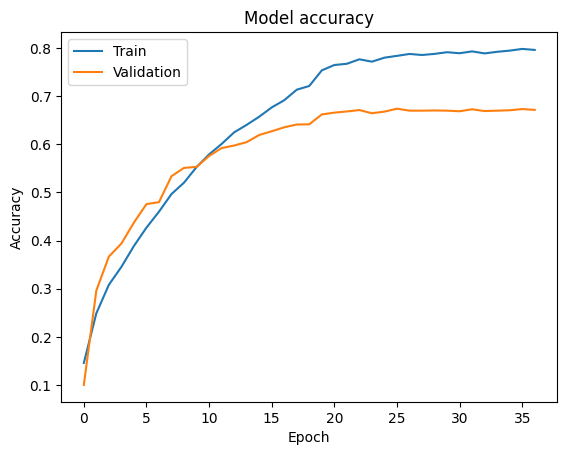

In [24]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## A visual rep of the training and validation loss across the epochs

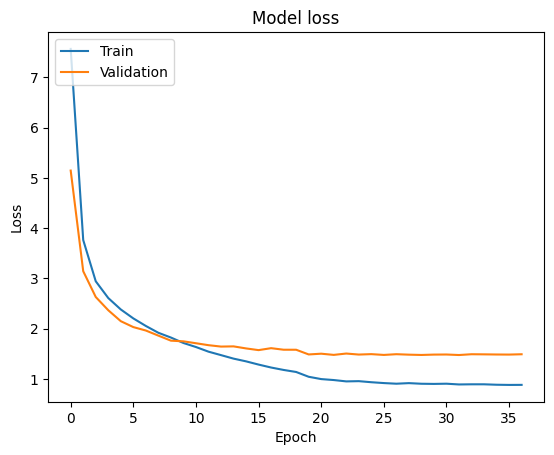

In [25]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## A visual of the confusion matrix for the 31 labels

54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 270ms/step


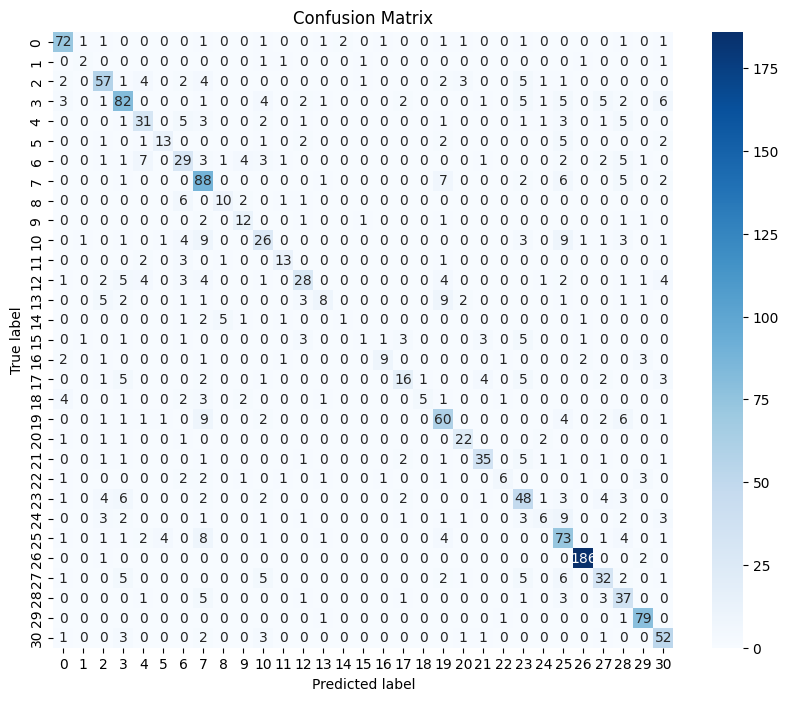

In [26]:
# Predict the values from the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get the true labels
y_true = test_generator.classes

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Classification report for every class

In [27]:
# Print classification report
class_labels = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_labels))

                           precision    recall  f1-score   support

                     acne       0.80      0.85      0.82        85
              acrochordon       0.40      0.29      0.33         7
        actinic keratosis       0.70      0.69      0.69        83
            benign tumors       0.68      0.68      0.68       121
                  bullous       0.58      0.56      0.57        55
              candidiasis       0.68      0.48      0.57        27
            drug eruption       0.48      0.48      0.48        61
                   eczema       0.57      0.79      0.66       112
          erythma nodesum       0.59      0.50      0.54        20
      ichthyosis vulgaris       0.55      0.63      0.59        19
       infestations bites       0.48      0.43      0.46        60
                   keloid       0.68      0.65      0.67        20
                   lichen       0.64      0.46      0.53        61
                    lupus       0.53      0.24      0.33     

## More model evaluation using the test data

### Shows the performance metrics such as:
* Precision
* Recall
* Accuracy

In [33]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict the values from the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get the true labels
y_true = test_generator.classes


# Print classification report
class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

# Extract precision, recall, and F1 score
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

# Print the metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")

# Print the full classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.6513 - loss: 1.6259
Test Accuracy: 66.07%
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step
Precision: 0.6574
Recall: 0.6607
F1 Score: 0.6478
Accuracy: 0.6607

Classification Report:
                           precision    recall  f1-score   support

                     acne       0.80      0.85      0.82        85
              acrochordon       0.40      0.29      0.33         7
        actinic keratosis       0.70      0.69      0.69        83
            benign tumors       0.68      0.68      0.68       121
                  bullous       0.58      0.56      0.57        55
              candidiasis       0.68      0.48      0.57        27
            drug eruption       0.48      0.48      0.48        61
                   eczema       0.57      0.79      0.66       112
          erythma nodesum       0.59      0.50      0.54        20
      ichthyosis vulgaris       0.55      0.63      0.59        19
       infestations bites       0

## Saving the model as a .h5 file for later use

In [29]:
model.save('/kaggle/working/skin_disease_cnn.h5')

### Trying to load model (as will be done later using flask)

In [32]:
# load model and show number of layers
from tensorflow.keras.models import load_model
the_model = load_model('/kaggle/working/skin_disease_cnn.h5')

print(len(the_model.layers))

8
